In [ ]:
import os
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pickle
from keras import layers
import keras
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip -o "/content/drive/MyDrive/CowImagesSoCool/BeefCattle_Muzzle_300.zip" -d "/content/drive/MyDrive/CowImagesSoCool/BeefCattle_Muzzle_300"

In [ ]:
# %cd "/content/drive/MyDrive/CowImagesSoCool/ImagesPickelFolder"

In [ ]:
# %pwd

In [ ]:
# !bash  "/content/drive/MyDrive/CowImagesSoCool/file1.sh"

In [ ]:
# # Define the path to the folder containing the dataset
# folder_path = "/content/drive/MyDrive/CowImagesSoCool/BeefCattle_Muzzle_300"
# file_list = os.listdir(folder_path)
# # print(file_list)
# # print(len(file_list)) #268
# file_file_list = [os.listdir('/content/drive/MyDrive/CowImagesSoCool/BeefCattle_Muzzle_300/'+i) for i in file_list]
# # print(file_file_list)
# # print(len(file_file_list))
# test =[[cv2.resize(cv2.imread(os.path.join('/content/drive/MyDrive/CowImagesSoCool/BeefCattle_Muzzle_300/',file_list[i],j)),(224,224)).astype('float32')/255 for j in file_file_list[i]] for i in range(len(file_list))]

In [ ]:
# for i in range(26):
#   with open('/content/drive/MyDrive/CowImagesSoCool/ImagesPickelFolder/list-'+str(i+1)+'.pkl', "wb") as fl:
#     pickle.dump(test[i*10:(i+1)*10], fl)

In [ ]:
# Print the sizes of training, validation, and testing datasets
print("Training data:",round(26*0.75))
print("Validation data:",round(26*0.20))
print("Testing data:",round(26*0.05))

Training data: 20
Validation data: 5
Testing data: 1


In [ ]:
# Define lists to store training and validation datasets
train_dataset = []
val_dataset = []
for i in range(20):
  with open("/content/drive/MyDrive/CowImagesSoCool/ImagesPickelFolder/list-"+str(i+1)+".pkl", "rb") as fl:
    train_dataset.extend(pickle.load(fl))
for i in range(20,25):
  with open("/content/drive/MyDrive/CowImagesSoCool/ImagesPickelFolder/list-"+str(i+1)+".pkl", "rb") as fl:
    val_dataset.extend(pickle.load(fl))

In [ ]:
print(train_dataset[0][0].shape)
print(len(train_dataset[2]))
val_dataset[0][0].shape

(224, 224, 3)
17


(224, 224, 3)

### Data Handling

In [ ]:
### Data Handling
# Define a custom data generator class for creating batches during training and validation
class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self,x1,x2,y,batch_size,dataset) :
        self.x1 = x1
        self.x2 = x2
        self.y = y
        self.batch_size = batch_size
        self.dataset = dataset

    def __len__(self) :
        # Calculate the number of batches per epoch
        # print((np.ceil(len(self.x1) / float(self.batch_size))).astype(int))
        return (np.ceil(len(self.x1) / float(self.batch_size))).astype(int)

    def __getitem__(self, idx) :
        batch_x1 = self.x1[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_x2 = self.x2[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx+1) * self.batch_size]
        return (np.array([(self.dataset[cow][cow_index]) for cow,cow_index in batch_x1]),np.array([(self.dataset[cow][cow_index]) for cow,cow_index in batch_x2])), np.array(batch_y)

In [ ]:
# Define the size of training and validation datasets
train_size = 45000
val_size = 15000

In [ ]:
def get_dataset(n,dataset1):
  mid = n//2
  data_index = [i for i in range(len(dataset1))]
  cow1_index = []
  cow2_index = []
  label = []
  for i in range(mid):
    '''
      Create pairs of similar and dissimilar images for training or validation
      n: size of the dataset
      dataset1: the dataset to create pairs from
      Return indices of images and their labels
      Format: (x1_index, x2_index, label)
      x1_index: index of the first image
      x2_index: index of the second image
      label: 0 for similar, 1 for dissimilar
    '''
    u_cow1,u_cow2 = random.sample(data_index, 2)
    temp_cow1 = [i for i in range(len(dataset1[u_cow1]))]
    temp_cow2 = [i for i in range(len(dataset1[u_cow2]))]
    anc,po = random.sample(temp_cow1,2)
    ne = random.choice(temp_cow2)
    cow1_index.append([u_cow1,anc])
    cow2_index.append([u_cow1,po])
    label.append(0)
    cow1_index.append([u_cow1,anc])
    cow2_index.append([u_cow2,ne])
    label.append(1)
  temp = list(zip(cow1_index,cow2_index,label))
  random.shuffle(temp)
  # print(len(temp))
  # print(temp[3])
  x1 = []
  x2 = []
  y = []
  for cow1,cow2,label in temp:
    x1.append(cow1)
    x2.append(cow2)
    y.append(label)
  del temp
  return x1,x2,y

In [ ]:

# Split the dataset into training and validation sets
siam_dataset_train = get_dataset(train_size,train_dataset)
siam_dataset_val = get_dataset(val_size,val_dataset)
print(siam_dataset_train[0][:5])
print(siam_dataset_train[1][:5])
print(siam_dataset_train[2][:5])

[[183, 5], [73, 2], [33, 11], [96, 0], [145, 14]]
[[183, 14], [73, 17], [33, 7], [164, 7], [145, 23]]
[0, 0, 0, 1, 0]


In [ ]:

# Extract indices and labels from the dataset
X1_train_index,X2_train_index,y_train = siam_dataset_train[0],siam_dataset_train[1],siam_dataset_train[2]
X1_val_index,X2_val_index,y_val = siam_dataset_val[0],siam_dataset_val[1],siam_dataset_val[2]

In [ ]:
def cosine_similarity(tensors):
    normalized_tensor1 = tf.nn.l2_normalize(tensors[0], axis=1)
    normalized_tensor2 = tf.nn.l2_normalize(tensors[1], axis=1)
    similarity = tf.reduce_sum(tf.multiply(normalized_tensor1, normalized_tensor2), axis=1)
    return tf.expand_dims(similarity, axis=-1)

In [ ]:
gpus = tf.config.list_physical_devices('TPU')
num_gpus = len(gpus)
print(f"Number of TPUS: {num_gpus}")

Number of TPUS: 0


### Encoder: Convolutional layers

In [ ]:
### Model Definition

# Define a Siamese neural network model using Keras
# The model consists of an encoder part followed by a cosine similarity layer and a classification layer
# The encoder part consists of convolutional layers followed by fully connected layers
# The model takes two input images, processes them through the encoder, and outputs a binary classification result

strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
#-----------ENCODER PART------------------
    reg_strength=0.0001
    Encoder = keras.Sequential(name='imageEncoder')
    Encoder.add(layers.Input(shape=(224,224,3)))
    Encoder.add(layers.Conv2D(64, (10,10),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(64, (10,10),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(64, (10,10),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(64, (10,10),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(128, (7,7),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(128, (7,7),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(128, (7,7),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(128, (7,7),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(256, (3,3),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(256, (3,3),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(256, (3,3),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(256, (3,3),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Flatten())
    Encoder.add(layers.Dense(1000))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.Dropout(0.2))
    Encoder.add(layers.Dense(500))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())

    image_1 = layers.Input(shape=(224, 224, 3), name='imageInput1')
    image_2 = layers.Input(shape=(224, 224, 3), name='imageInput2')
    encoded_rep_1 = Encoder(image_1)
    encoded_rep_2 = Encoder(image_2)
    distance = layers.Lambda(cosine_similarity, name='cosineSimilarityMetric',output_shape=(None,1))([encoded_rep_1, encoded_rep_2])
    output = layers.Dense(2, activation='softmax',name='siameseOutput')(distance)
    siamese_model = keras.Model(inputs=[image_1, image_2], outputs=[output],name="cowMuzzleSiameseModel")
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=(0.001)), loss='sparse_categorical_crossentropy', metrics=["accuracy"])


Number of devices: 1


In [ ]:
siamese_model.summary()

Model: "cowMuzzleSiameseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ imageInput1 (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ imageInput2 (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ imageEncoder (Sequential) │ (None, 500)            │      5,333,740 │ imageInput1[0][0],     │
│                           │                        │                │ imageInput2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cosineSimilarityMetric    │ (None, None, 1)        │              0 │ imageEncoder[0][0],    │
│ (Lambda)                  │                        │                │ imageEncoder[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ siameseOutput (Dense)     │ (None, None, 2)        │              4 │ cosineSimilarityMetri… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,333,744 (20.35 MB)

 Trainable params: 5,328,952 (20.33 MB)

 Non-trainable params: 4,792 (18.72 KB)

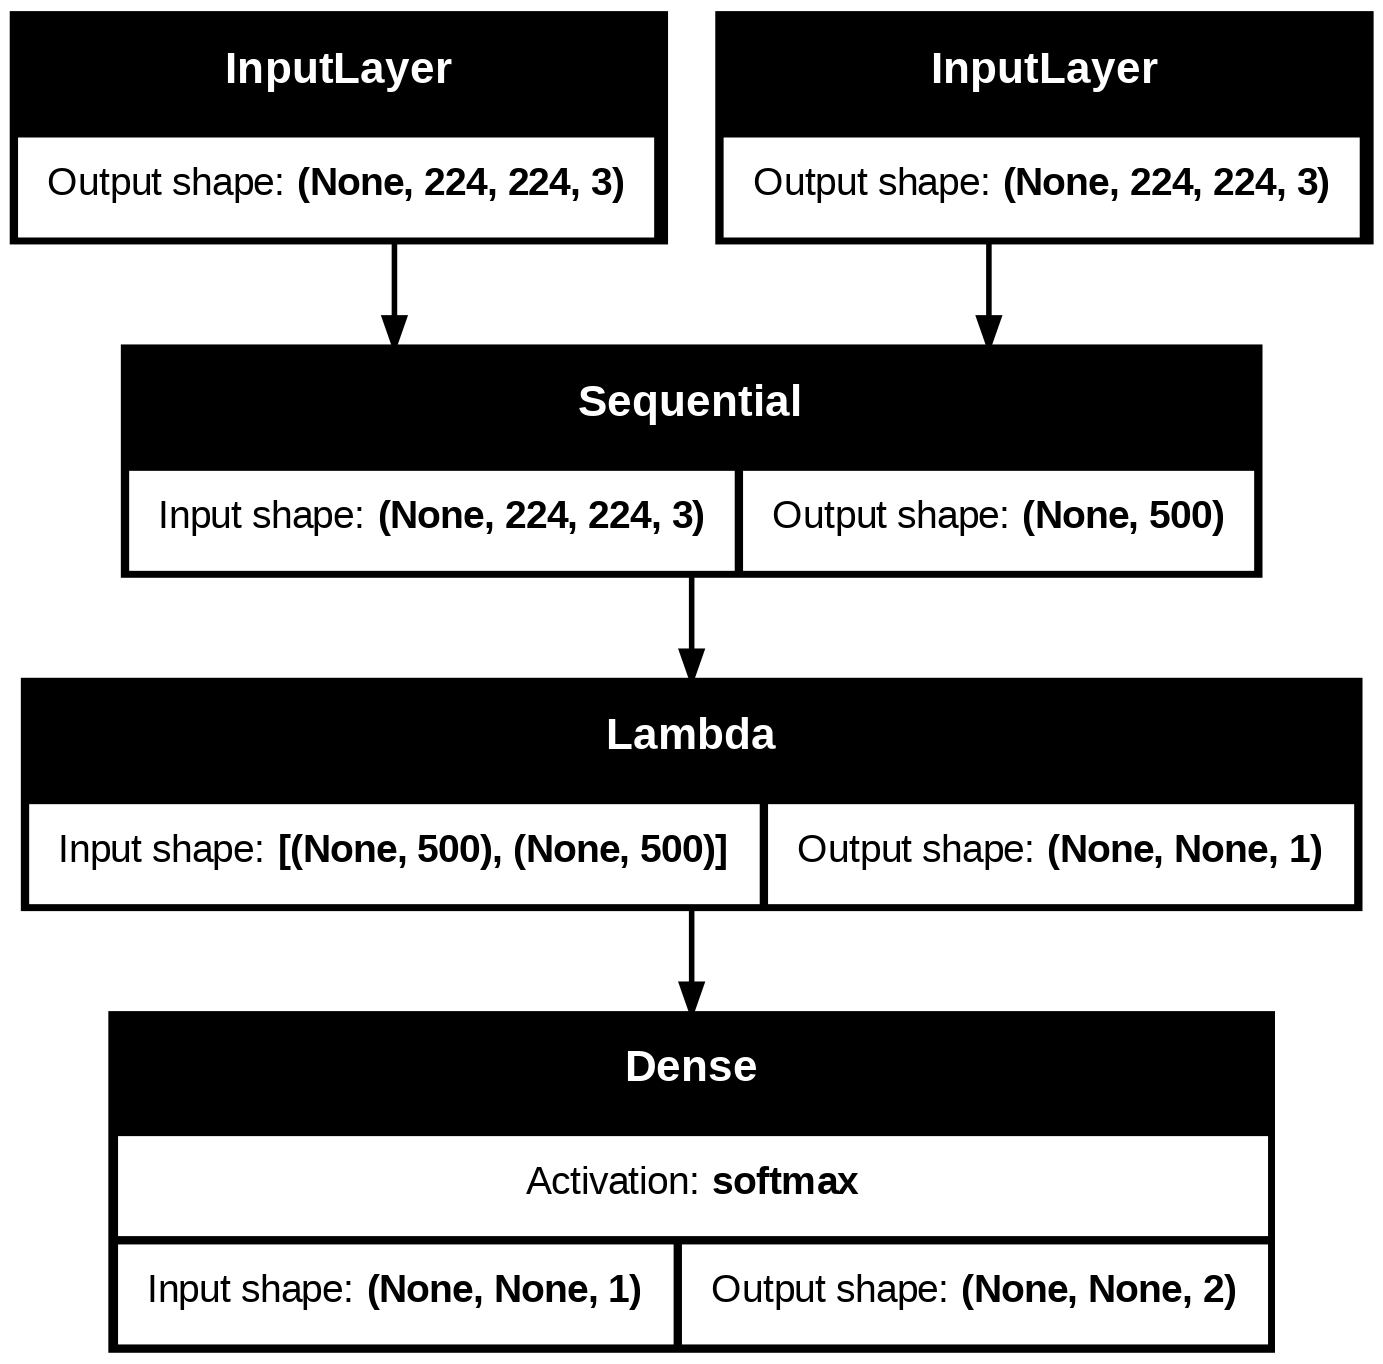

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(siamese_model, to_file=dot_img_file, show_shapes=True, show_layer_activations=True)

In [ ]:
### Training
# Define batch size
batch_size = 64
my_training_batch_generator = My_Custom_Generator(X1_train_index,X2_train_index,y_train, batch_size,train_dataset)
my_validation_batch_generator = My_Custom_Generator(X1_val_index,X2_val_index,y_val, batch_size,val_dataset)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience = 3,
                                              verbose=1,
                                              )
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CowImagesSoCool/CowMuzzleSiameseModel.keras", monitor="val_loss", save_best_only=True, verbose=1)

In [ ]:
History=siamese_model.fit(x=my_training_batch_generator,
                   epochs = 10,
                   verbose = 1,
                   callbacks=[early_stop,checkpoint],
                   validation_data = my_validation_batch_generator,
                   )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7143 - loss: 197.1706
Epoch 1: val_loss improved from inf to 85.80819, saving model to /content/drive/MyDrive/CowImagesSoCool/CowMuzzleSiameseModel.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 1045s 1s/step - accuracy: 0.7144 - loss: 197.1092 - val_accuracy: 0.7397 - val_loss: 85.8082
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8521 - loss: 67.3339
Epoch 2: val_loss improved from 85.80819 to 29.29658, saving model to /content/drive/MyDrive/CowImagesSoCool/CowMuzzleSiameseModel.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 1020s 1s/step - accuracy: 0.8521 - loss: 67.3130 - val_accuracy: 0.8250 - val_loss: 29.2966
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8930 - loss: 22.8554
Epoch 3: val_loss improved from 29.29658 to 9.74704, saving model to /content/drive/MyDrive/CowImagesSoCool/CowMuzzleSiameseModel.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 1020s 1s/step - accuracy: 0.8930 - loss: 22.8482 - val_accuracy: 0.8610 - v

In [ ]:
plt.plot(History.history['loss'], label='loss')
plt.plot(History.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/CowImagesSoCool/CowMuzzleSiameseModel.keras',safe_mode=False)

In [ ]:
# Define the path to the folder containing the dataset
# folder_path = "/content/drive/MyDrive/CowImagesSoCool/BeefCattle_Muzzle_300"
# file_list = os.listdir(folder_path)
# print(file_list)
# print(len(file_list)) #268
# file_file_list = [os.listdir('/content/drive/MyDrive/CowImagesSoCool/BeefCattle_Muzzle_300/'+i) for i in file_list]
# print(file_file_list)
# print(len(file_file_list))
# test =[[cv2.resize(cv2.imread(os.path.join('/content/drive/MyDrive/CowImagesSoCool/BeefCattle_Muzzle_300/',file_list[i],j)),(224,224)).astype('float32')/255 for j in file_file_list[i]] for i in range(260,len(file_list))]

In [ ]:
# with open('/content/drive/MyDrive/CowImagesSoCool/ImagesPickelFolder/test.pkl', "wb") as fl:
#   pickle.dump(test[0:], fl)

In [ ]:
test_dataset = []

In [ ]:
for i in range(20,25):
  with open("/content/drive/MyDrive/CowImagesSoCool/ImagesPickelFolder/list-"+str(i+1)+".pkl", "rb") as fl:
      test_dataset.extend(pickle.load(fl))

In [ ]:
test_dataset[0][0].shape

(224, 224, 3)

In [ ]:
test_siamese_dataset = get_dataset(n=1000,dataset1=test_dataset)

In [ ]:
test_siamese_yactual=test_siamese_dataset[2]

In [ ]:
my_test_batch_generator=My_Custom_Generator(test_siamese_dataset[0],test_siamese_dataset[1],test_siamese_dataset[2], 64,test_dataset)

In [ ]:
len(my_test_batch_generator)

16

In [ ]:
def cosine_similarity(v1, v2):
    '''compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)'''
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

In [ ]:
# Create a new model with the encoder layers as output
encoder_layer = keras.Model(inputs=loaded_model.get_layer('imageEncoder').input, outputs=loaded_model.get_layer("imageEncoder").output)
classifier = keras.Model(inputs=loaded_model.get_layer('siameseOutput').input, outputs=loaded_model.get_layer('siameseOutput').output)
output_prob = []
for batch_input1, batch_input2, in my_test_batch_generator:
    if len(batch_input1[0]) == 0:
          print("Warning: Empty batch encountered. Skipping.")
          break
    # Get the encoder representations
    # print(len(batch_input1[0]),batch_input2)
    encoded_rep1 = encoder_layer.predict([batch_input1[0]])
    encoded_rep2 = encoder_layer.predict([batch_input1[1]])
    # print(encoded_rep1.shape)
    # print(encoded_rep2.shape)
    for i in range(len(encoded_rep1)):
        distance = cosine_similarity(encoded_rep1[i], encoded_rep2[i])
        # print(distance)
        distance = np.array([distance]).reshape((1, 1, 1))
        output_prob.append(classifier.predict(distance)[0])


In [ ]:
output_prob

In [ ]:
# test_siamese_ypred = [0 if i[0]>0.95 else 1 for i in test_siamese_ypred_keras]

In [ ]:
test_siamese_ypred = [0 if i[0][0]>i[0][1] else 1 for i in output_prob]

In [ ]:
len(test_siamese_yactual)

1000

In [ ]:
len(test_siamese_ypred)

1000

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_siamese_yactual,test_siamese_ypred)
auc_keras = auc(fpr_keras, tpr_keras)

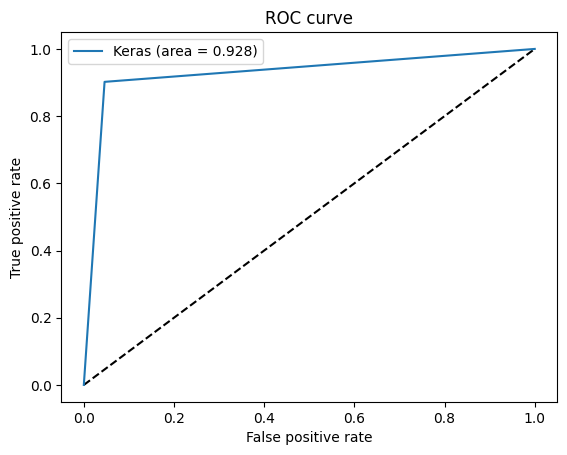

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
loaded_model.summary()

Model: "cowMuzzleSiameseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ imageInput1 (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ imageInput2 (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ imageEncoder (Sequential) │ (None, 500)            │      5,333,740 │ imageInput1[0][0],     │
│                           │                        │                │ imageInput2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cosineSimilarityMetric    │ (None, None, 1)        │              0 │ imageEncoder[0][0],    │
│ (Lambda)                  │                        │                │ imageEncoder[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ siameseOutput (Dense)     │ (None, None, 2)        │              4 │ cosineSimilarityMetri… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,991,650 (61.00 MB)

 Trainable params: 5,328,952 (20.33 MB)

 Non-trainable params: 4,792 (18.72 KB)

 Optimizer params: 10,657,906 (40.66 MB)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_siamese_yactual , test_siamese_ypred,target_names=['similar','dissimilar']))

              precision    recall  f1-score   support

     similar       0.91      0.95      0.93       500
  dissimilar       0.95      0.90      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

